In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import sklearn.linear_model
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import pydot 
import graphviz

In [30]:
raw_df = pd.read_csv("data/May2018-May2019.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 644496 Airbnb listings


,date,id,host_id,neighbourhood,room_type,price,minimum_nights,calculated_host_listings_count
0,5/9/18,2515,2758,Harlem,Private room,59.0,2,3
1,5/9/18,2539,2787,Kensington,Private room,79.0,1,7
2,5/9/18,2595,2845,Midtown,Entire home/apt,225.0,1,2


In [31]:
raw_df.date = pd.to_datetime(raw_df.date) 


In [32]:
raw_df.isna().sum()


date                              0
id                                0
host_id                           0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

In [33]:
raw_df.price.value_counts()

150.0     26871
100.0     26030
50.0      20629
60.0      19340
200.0     18524
          ...  
891.0         1
2549.0        1
3598.0        1
901.0         1
817.0         1
Name: price, Length: 997, dtype: int64

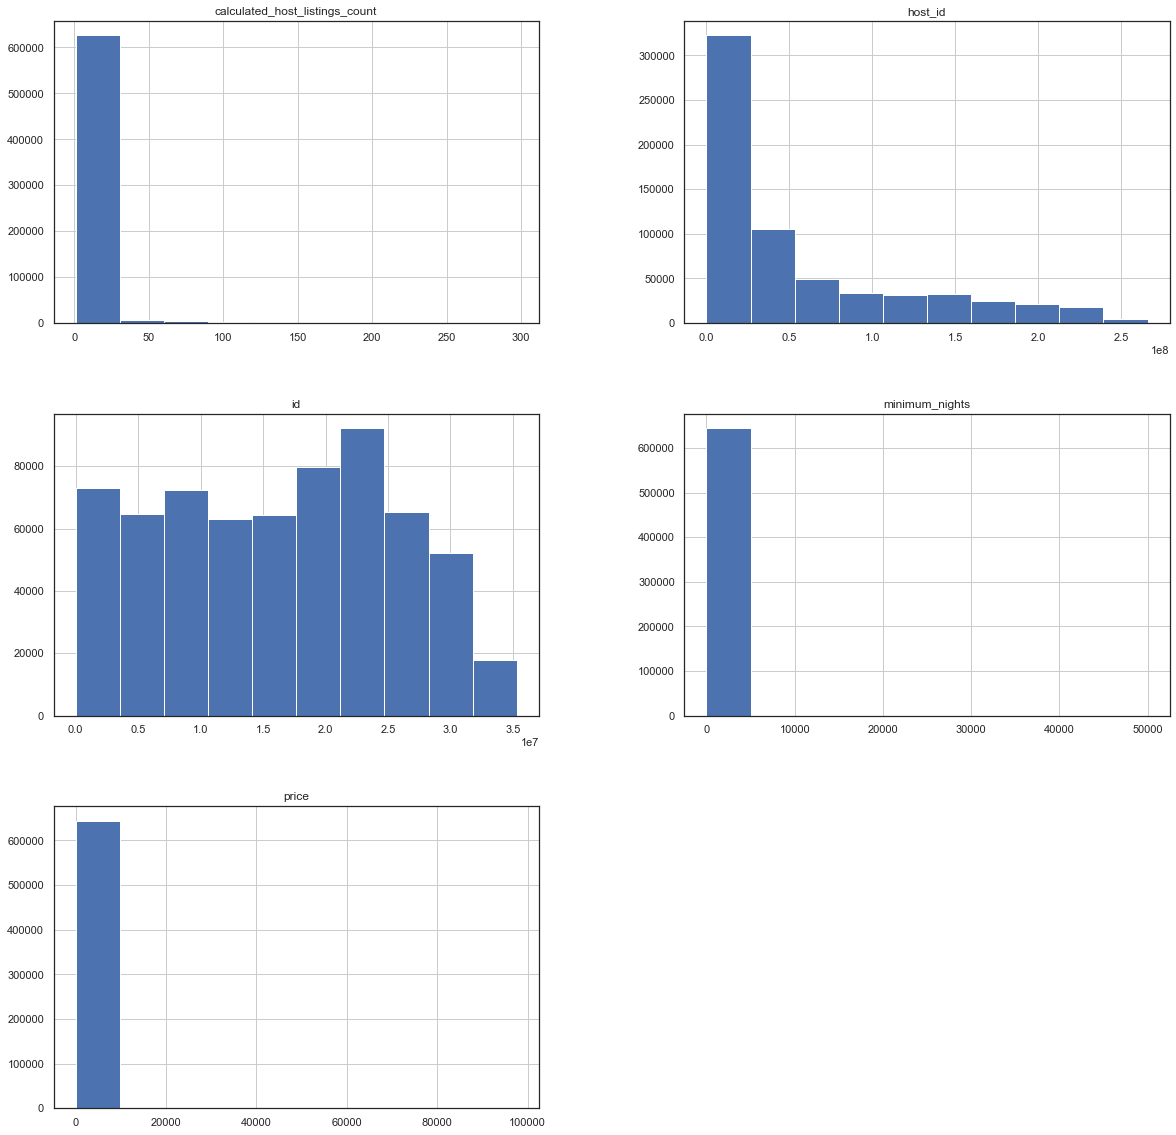

In [34]:
# Replacing columns with f/t with 0/1
raw_df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
raw_df.hist(figsize=(20,20));

In [35]:
raw_df.room_type.value_counts()


Entire home/apt    335277
Private room       294527
Shared room         14692
Name: room_type, dtype: int64

In [36]:
print("Mean nightly price of listings in each year on Airbnb in NYC:")
print(round(raw_df.set_index('date').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in NYC:
date
2018-01-01    150.10
2019-01-01    152.02
Freq: AS-JAN, Name: price, dtype: float64


In [37]:
host_listings_count = raw_df.host_id.value_counts()
host_listings_count

107434423    1595
30283594     1471
22541573     1067
16098958     1032
219517861     964
             ... 
79653673        1
27335399        1
2599473         1
228024872       1
17913899        1
Name: host_id, Length: 59282, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


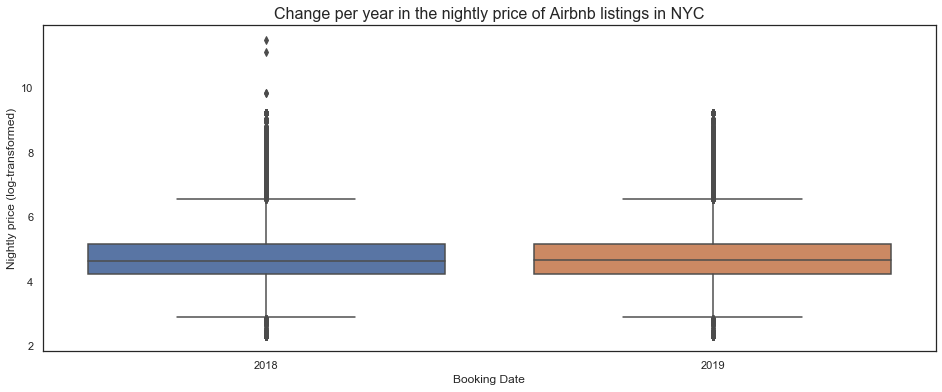

In [38]:
plt.figure(figsize=(16,6))
sns.boxplot(raw_df.date.dt.year, np.log(raw_df.price))
plt.xlabel('Booking Date', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in NYC', fontsize=16)
plt.show()

In [39]:
raw_df.describe()

,id,host_id,price,minimum_nights,calculated_host_listings_count
count,6.444960e+05,6.444960e+05,644496.000000,644496.000000,644496.000000
mean,1.620088e+07,5.550720e+07,150.837322,6.817555,4.502957
std,9.270845e+06,6.421395e+07,270.246080,125.969881,17.532499
min,2.454000e+03,2.830000e+02,0.000000,1.000000,1.000000
25%,8.303337e+06,7.040483e+06,69.000000,1.000000,1.000000
50%,1.667857e+07,2.655670e+07,105.000000,2.000000,1.000000
75%,2.346603e+07,8.375453e+07,175.000000,5.000000,2.000000
max,3.530389e+07,2.657038e+08,97598.000000,50000.000000,297.000000


In [40]:
print(f"Nightly advertised prices range from ${min(raw_df.price)} to ${max(raw_df.price)}.")


Nightly advertised prices range from $0.0 to $97598.0.


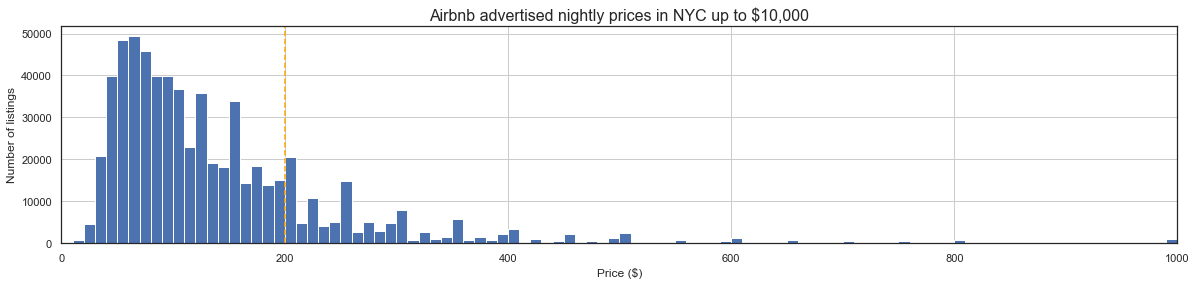

In [41]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

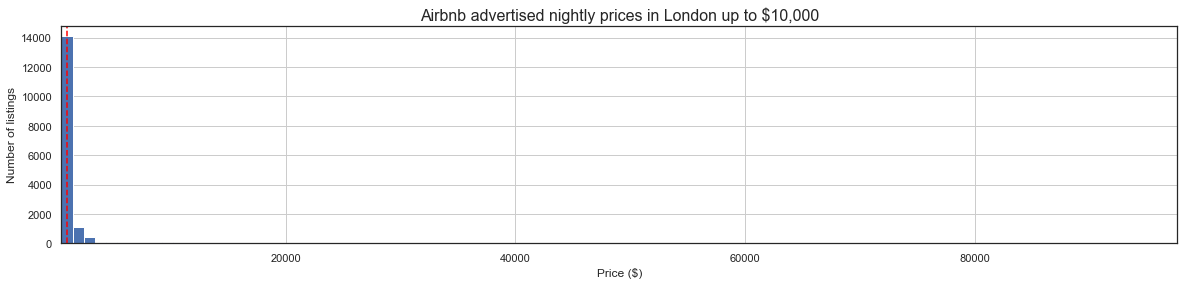

In [42]:
# Distribution of prices from $500 upwards
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(500, max(raw_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [43]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    raw_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

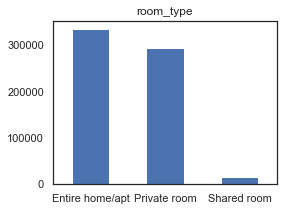

Entire home/apt    0.520216
Private room       0.456988
Shared room        0.022796
Name: room_type, dtype: float64


In [44]:
for col in ['room_type']:
    category_count_plot(col, figsize=(4,3))
    print(raw_df[col].value_counts(normalize=True))

In [45]:
transformed_df = pd.get_dummies(raw_df)

In [19]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

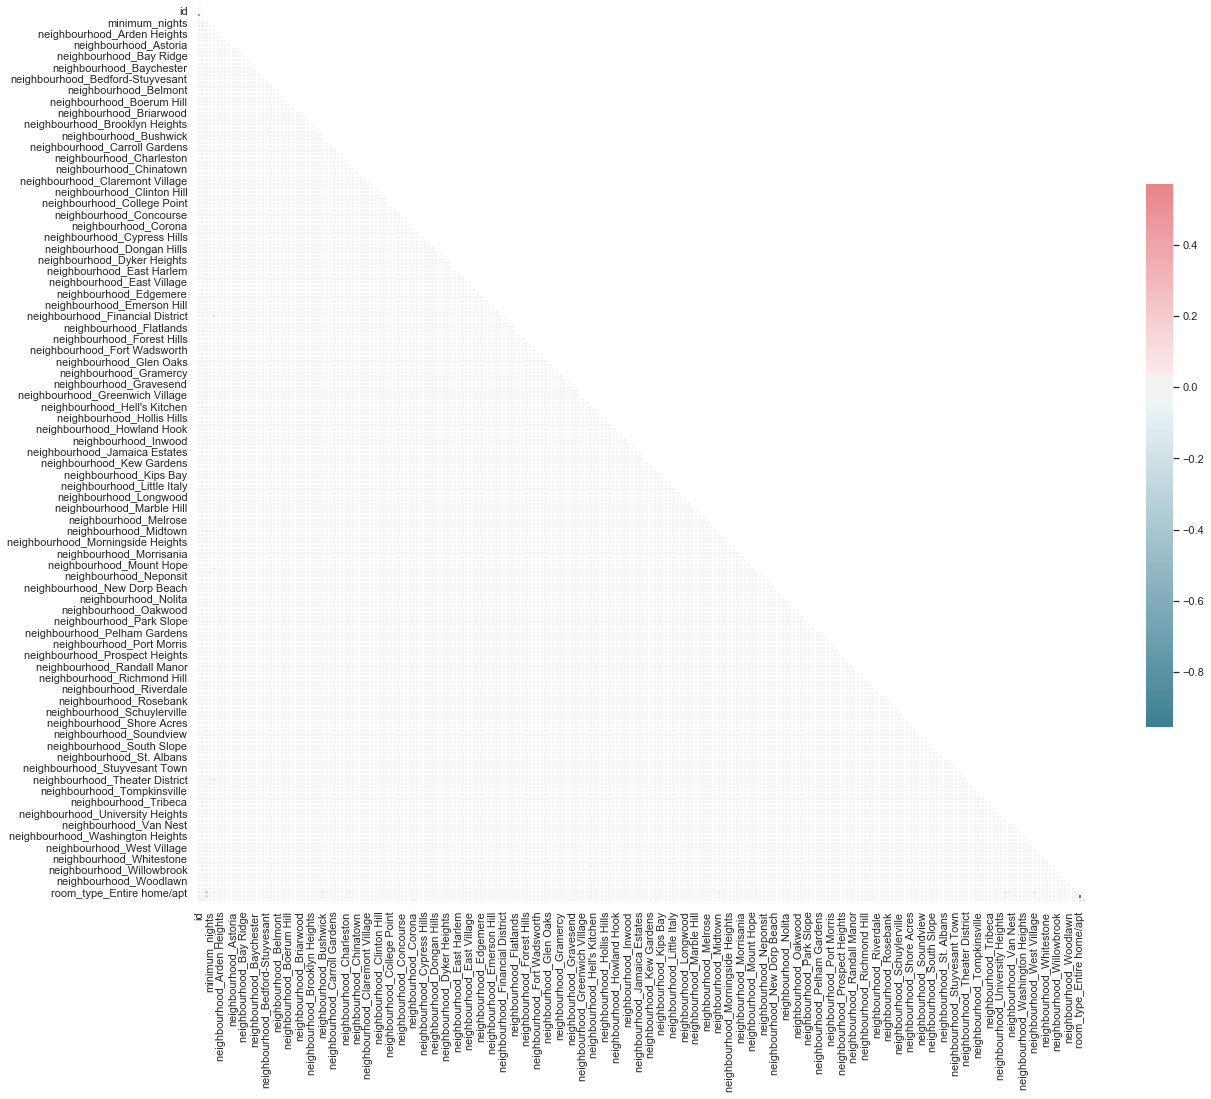

In [20]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

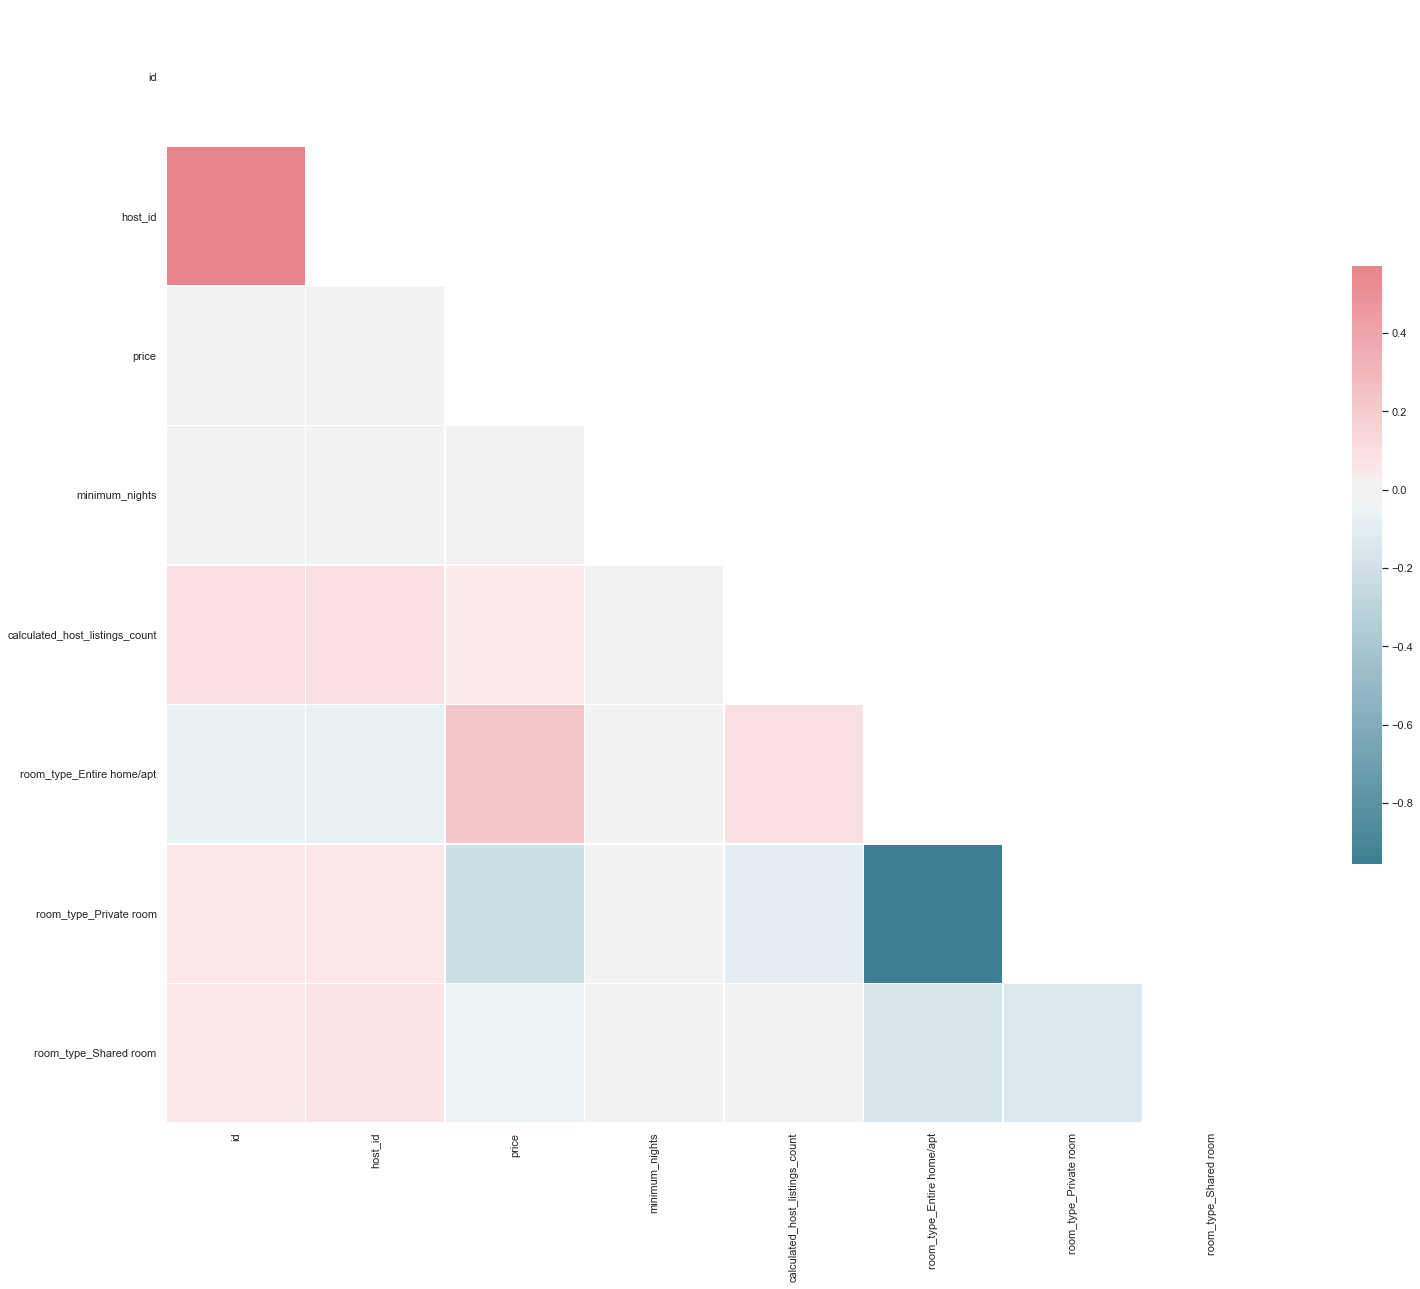

In [21]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

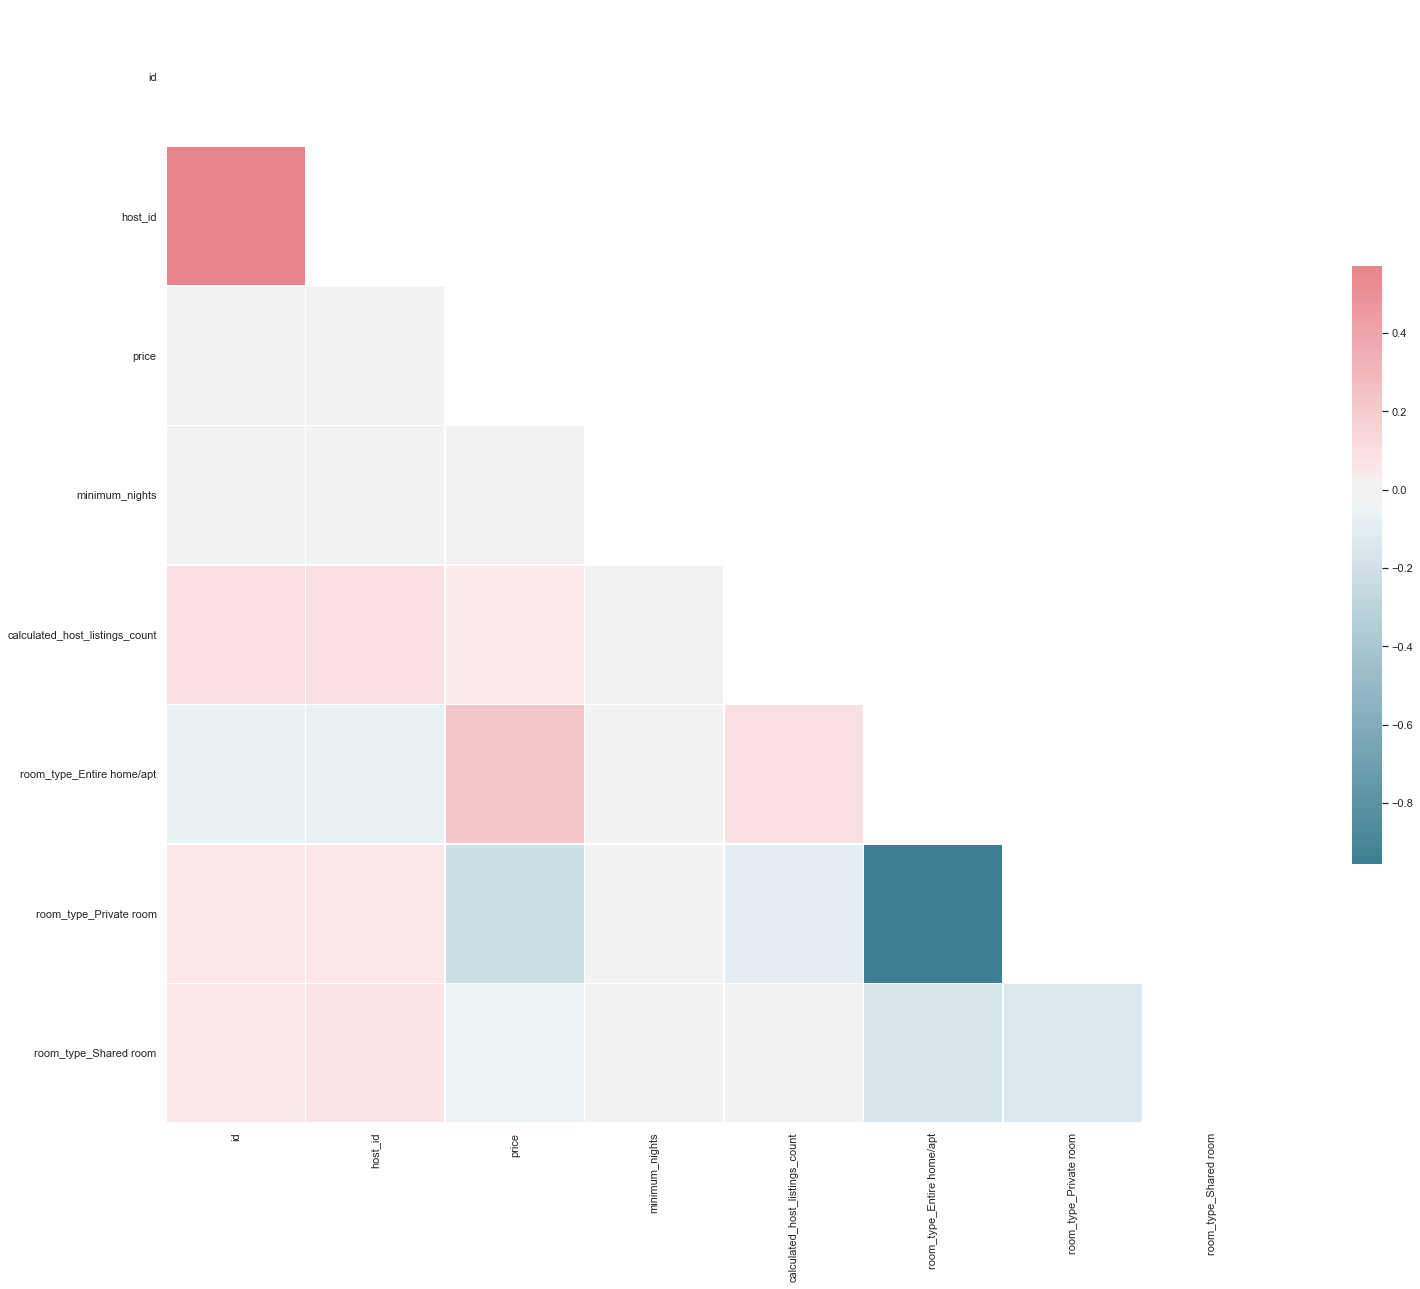

In [22]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

In [46]:
numerical_columns = ['price', 'id', 'calculated_host_listings_count', 'minimum_nights']


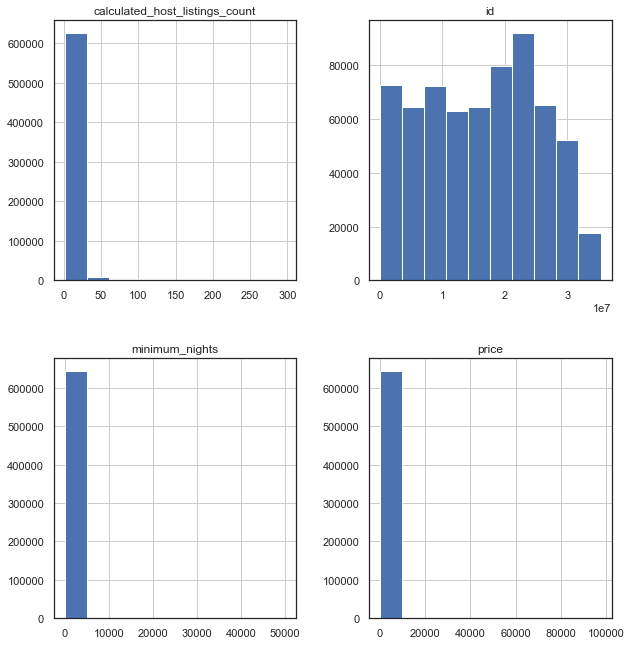

In [47]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [86]:
transformed_df['date'] = pd.to_datetime(transformed_df['date'])
transformed_df['day_of_week'] = transformed_df['date'].dt.day_name()

In [83]:
transformed_df["new_year_day"] = transformed_df['date'].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
transformed_df['day_of_the_year'] = transformed_df.apply(lambda x: (x['date'] - x['new_year_day']).days + 1, axis=1)

In [84]:
transformed_df.tail(40)

,date,id,host_id,price,...,room_type_Shared room,new_year_day,day_of_the_year,day_of_week
644456,2019-05-03,35275415,214738765,55.0,...,1,2019-01-01,123,Friday
644457,2019-05-03,35275591,51179270,78.0,...,0,2019-01-01,123,Friday
644458,2019-05-03,35275920,265576141,75.0,...,0,2019-01-01,123,Friday
644459,2019-05-03,35277302,6057887,59.0,...,0,2019-01-01,123,Friday
644460,2019-05-03,35277447,239989054,300.0,...,0,2019-01-01,123,Friday
644461,2019-05-03,35278572,15188018,250.0,...,0,2019-01-01,123,Friday
644462,2019-05-03,35278838,3644678,30.0,...,0,2019-01-01,123,Friday
644463,2019-05-03,35279737,183088406,60.0,...,0,2019-01-01,123,Friday
644464,2019-05-03,35280253,125441487,145.0,...,0,2019-01-01,123,Friday
644465,2019-05-03,35280874,19645976,150.0,...,0,2019-01-01,123,Friday


In [63]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.drop(["date", "new_year_day"], axis=1)),columns=X.drop(["date", "new_year_day"], axis=1).columns)

In [64]:
X.head()

,id,host_id,minimum_nights,calculated_host_listings_count,...,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,day_of_the_year
0,-1.747239,-0.864368,-0.038244,-0.085724,...,-1.041283,1.090065,-0.152735,-0.388443
1,-1.747236,-0.864368,-0.046182,0.142424,...,-1.041283,1.090065,-0.152735,-0.388443
2,-1.747230,-0.864367,-0.046182,-0.142761,...,0.960354,-0.917377,-0.152735,-0.388443
3,-1.747151,-0.864346,-0.014429,-0.085724,...,-1.041283,1.090065,-0.152735,-0.388443
4,-1.747117,-0.864339,-0.030305,-0.199798,...,-1.041283,1.090065,-0.152735,-0.388443


In [65]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [66]:
# MOST SUCCESSFUL MODEL
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 2.1 minutes

Training MSE: 27887.0195
Validation MSE: 20490.1981

Training r2: 0.6471
Validation r2: 0.5826


In [108]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg.tail()

,weight
room_type_Entire home/apt,0.028453
neighbourhood_Chelsea,0.029882
neighbourhood_Little Italy,0.043453
neighbourhood_Clinton Hill,0.090174
neighbourhood_Astoria,0.244698


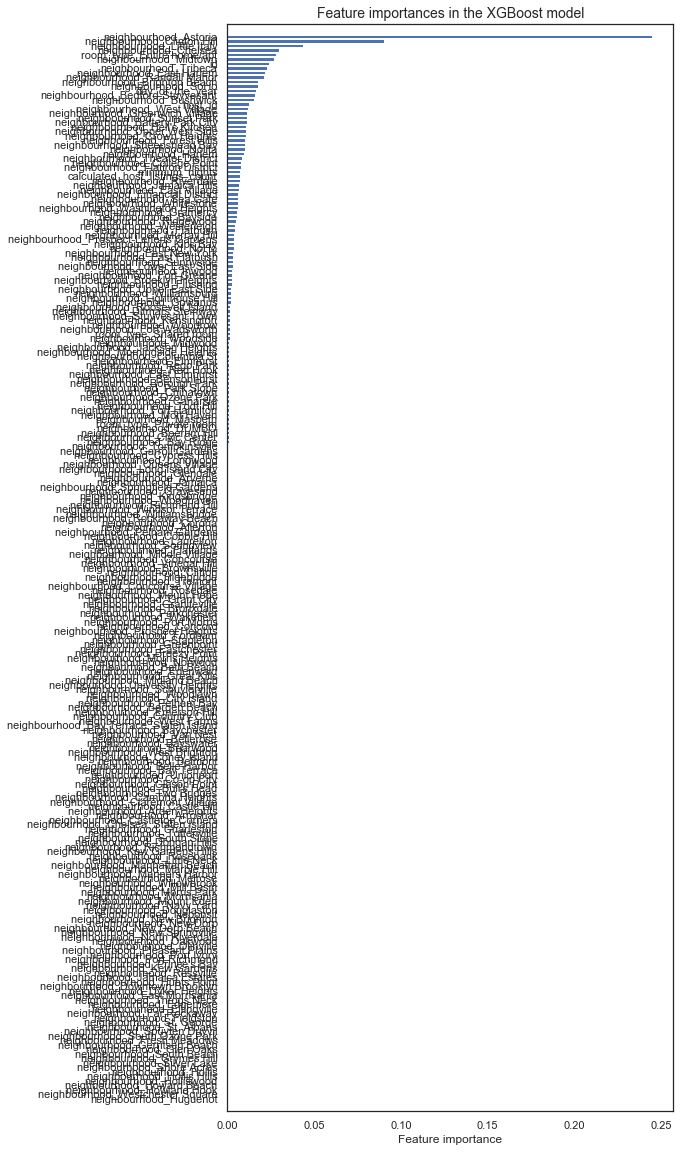

In [68]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [69]:
print("Median number of listings per host:", int(raw_df.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(raw_df.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(raw_df[raw_df.calculated_host_listings_count == 1])/len(raw_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 5
67% of listings are from hosts with one listing.


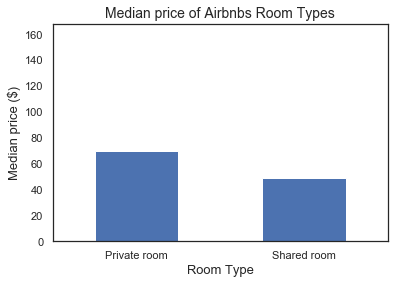

In [70]:
raw_df.groupby('room_type').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs Room Types', fontsize=14)
plt.xlabel('Room Type', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

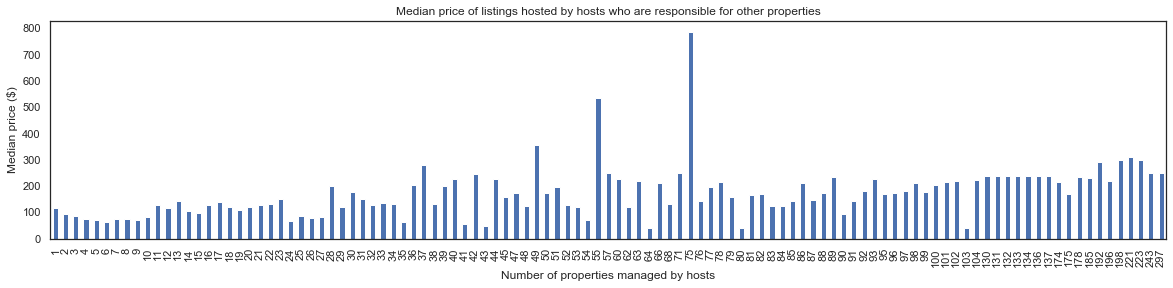

In [71]:
# Median price for different host listing counts
plt.figure()
raw_df.groupby('calculated_host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)');

In [89]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               30464     
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 129,537
Trainable params: 129,537
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [73]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Epoch 1/100
1813/1813 [==============================] - 5s 3ms/step - loss: 76286.6953 - mean_squared_error: 76286.6953 - val_loss: 50184.9180 - val_mean_squared_error: 50184.9180
Epoch 2/100
1813/1813 [==============================] - 5s 3ms/step - loss: 75451.9219 - mean_squared_error: 75451.9219 - val_loss: 50027.2266 - val_mean_squared_error: 50027.2266
Epoch 3/100
1813/1813 [==============================] - 5s 3ms/step - loss: 75260.6562 - mean_squared_error: 75260.6562 - val_loss: 49743.6602 - val_mean_squared_error: 49743.6602
Epoch 4/100
1813/1813 [==============================] - 5s 3ms/step - loss: 75034.5156 - mean_squared_error: 75034.5156 - val_loss: 49545.5273 - val_mean_squared_error: 49545.5273
Epoch 5/100
1813/1813 [==============================] - 5s 3ms/step - loss: 74698.7969 - mean_squared_error: 74698.7969 - val_loss: 49309.6562 - val_mean_squared_error: 49309.6562
Epoch 6/100
1813/1813 [==============================] - 5s 3ms/step - loss: 73663.2656 - mean_

1813/1813 [==============================] - 5s 3ms/step - loss: 62934.4414 - mean_squared_error: 62934.4414 - val_loss: 38215.9648 - val_mean_squared_error: 38215.9648
Epoch 47/100
1813/1813 [==============================] - 5s 3ms/step - loss: 62572.6992 - mean_squared_error: 62572.6992 - val_loss: 36886.2422 - val_mean_squared_error: 36886.2422
Epoch 48/100
1813/1813 [==============================] - 4s 2ms/step - loss: 62473.8281 - mean_squared_error: 62473.8281 - val_loss: 37006.3828 - val_mean_squared_error: 37006.3828
Epoch 49/100
1813/1813 [==============================] - 4s 2ms/step - loss: 62339.3711 - mean_squared_error: 62339.3711 - val_loss: 36794.4883 - val_mean_squared_error: 36794.4883
Epoch 50/100
1813/1813 [==============================] - 5s 3ms/step - loss: 62084.8945 - mean_squared_error: 62084.8945 - val_loss: 36567.3672 - val_mean_squared_error: 36567.3672
Epoch 51/100
1813/1813 [==============================] - 5s 3ms/step - loss: 62098.1836 - mean_squared

1813/1813 [==============================] - 5s 2ms/step - loss: 58005.5508 - mean_squared_error: 58005.5508 - val_loss: 35044.7188 - val_mean_squared_error: 35044.7188
Epoch 92/100
1813/1813 [==============================] - 5s 3ms/step - loss: 57757.7031 - mean_squared_error: 57757.7031 - val_loss: 34394.5781 - val_mean_squared_error: 34394.5781
Epoch 93/100
1813/1813 [==============================] - 4s 2ms/step - loss: 58068.8555 - mean_squared_error: 58068.8555 - val_loss: 35156.1875 - val_mean_squared_error: 35156.1875
Epoch 94/100
1813/1813 [==============================] - 5s 3ms/step - loss: 58315.1719 - mean_squared_error: 58315.1719 - val_loss: 35447.1562 - val_mean_squared_error: 35447.1562
Epoch 95/100
1813/1813 [==============================] - 5s 3ms/step - loss: 58363.8047 - mean_squared_error: 58363.8047 - val_loss: 34006.5039 - val_mean_squared_error: 34006.5039
Epoch 96/100
1813/1813 [==============================] - 5s 3ms/step - loss: 57516.4922 - mean_squared

In [77]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

In [90]:
nn_model_evaluation(nn2)


Training MSE: 101864.6506
Validation MSE: 71544.511

Training r2: -0.2891
Validation r2: -0.4575


KeyError: 'price'

In [91]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               30464     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 513       
Total params: 261,377
Trainable params: 261,377
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [94]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")


Epoch 1/15
1813/1813 [==============================] - 8s 5ms/step - loss: 75207.8750 - mean_squared_error: 75163.5703 - val_loss: 49528.4297 - val_mean_squared_error: 49485.7031
Epoch 2/15
1813/1813 [==============================] - 9s 5ms/step - loss: 74690.2188 - mean_squared_error: 74646.6172 - val_loss: 49054.8633 - val_mean_squared_error: 49010.0273
Epoch 3/15
1813/1813 [==============================] - 9s 5ms/step - loss: 73393.8125 - mean_squared_error: 73346.2422 - val_loss: 48711.5820 - val_mean_squared_error: 48661.9375
Epoch 4/15
1813/1813 [==============================] - 9s 5ms/step - loss: 72223.5703 - mean_squared_error: 72170.9609 - val_loss: 46556.8984 - val_mean_squared_error: 46500.6836
Epoch 5/15
1813/1813 [==============================] - 8s 5ms/step - loss: 70120.8984 - mean_squared_error: 70063.0391 - val_loss: 45522.9219 - val_mean_squared_error: 45462.9375
Epoch 6/15
1813/1813 [==============================] - 9s 5ms/step - loss: 70054.9688 - mean_square

In [95]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

Training MSE: 63744.8219
Validation MSE: 37041.7494

Training r2: 0.1933
Validation r2: 0.2454


KeyError: 'price'

In [96]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

# Visualising the neural network
SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 128)               30464     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_26 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 261,377
Trainable params: 261,377
Non-trainable params: 0
_________________________________________________________________
None
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


AttributeError: 'NoneType' object has no attribute 'create'

In [98]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Epoch 1/15
1813/1813 [==============================] - 8s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/15
1813/1813 [==============================] - 9s 5ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/15
1813/1813 [==============================] - 8s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/15
1813/1813 [==============================] - 8s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/15
1813/1813 [==============================] - 8s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 6/15
1813/1813 [==============================] - 8s 4ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 7/15
1813/1813 [==============================] - 8s 4ms/step - loss: nan - mean_s

In [99]:
nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [100]:
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

# Visualising the neural network
SVG(model_to_dot(nn5, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 237)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               30464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [102]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

Epoch 1/15
1813/1813 [==============================] - 10s 6ms/step - loss: 78763.4062 - mean_squared_error: 78763.4062 - val_loss: 52186.2617 - val_mean_squared_error: 52186.2617
Epoch 2/15
1813/1813 [==============================] - 8s 4ms/step - loss: 78470.9062 - mean_squared_error: 78470.9062 - val_loss: 52611.4844 - val_mean_squared_error: 52611.4844
Epoch 3/15
1813/1813 [==============================] - 8s 5ms/step - loss: 78458.0547 - mean_squared_error: 78458.0547 - val_loss: 51745.7148 - val_mean_squared_error: 51745.7148
Epoch 4/15
1813/1813 [==============================] - 9s 5ms/step - loss: 78335.0391 - mean_squared_error: 78335.0391 - val_loss: 52414.6992 - val_mean_squared_error: 52414.6992
Epoch 5/15
1813/1813 [==============================] - 9s 5ms/step - loss: 78220.1641 - mean_squared_error: 78220.1641 - val_loss: 51334.7188 - val_mean_squared_error: 51334.7188
Epoch 6/15
1813/1813 [==============================] - 8s 5ms/step - loss: 78191.8672 - mean_squar

In [103]:
nn_model_evaluation(nn5, skip_epochs=2)

Training MSE: 74273.484
Validation MSE: 44415.7155

Training r2: 0.0601
Validation r2: 0.0951


KeyError: 'price'

In [104]:
nn6 = models.Sequential()
nn6.add(layers.Dropout(0.2, input_shape=(X_train.shape[1],)))
nn6.add(layers.Dense(128, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(256, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(512, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

# Visualising the neural network
SVG(model_to_dot(nn6, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 237)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               30464     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [106]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=512,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

Epoch 1/15
907/907 [==============================] - 7s 7ms/step - loss: 76684.9844 - mean_squared_error: 76684.9844 - val_loss: 50309.1875 - val_mean_squared_error: 50309.1875
Epoch 2/15
907/907 [==============================] - 6s 7ms/step - loss: 76582.0703 - mean_squared_error: 76582.0703 - val_loss: 50568.9258 - val_mean_squared_error: 50568.9258
Epoch 3/15
907/907 [==============================] - 6s 7ms/step - loss: 76499.3203 - mean_squared_error: 76499.3203 - val_loss: 50272.4727 - val_mean_squared_error: 50272.4727
Epoch 4/15
907/907 [==============================] - 7s 8ms/step - loss: 76403.5625 - mean_squared_error: 76403.5625 - val_loss: 50170.6172 - val_mean_squared_error: 50170.6172
Epoch 5/15
907/907 [==============================] - 7s 7ms/step - loss: 76340.0469 - mean_squared_error: 76340.0469 - val_loss: 50775.3047 - val_mean_squared_error: 50775.3047
Epoch 6/15
907/907 [==============================] - 7s 7ms/step - loss: 76256.4219 - mean_squared_error: 762

In [107]:
nn_model_evaluation(nn6)

Training MSE: 72223.3657
Validation MSE: 42533.2564

Training r2: 0.086
Validation r2: 0.1335


KeyError: 'price'